In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftshift
import scipy.signal
import scipy.io.wavfile
import matplotlib.pyplot as plt

from rfutils import *

In [2]:
plot_spect(sig, fs)

NameError: name 'sig' is not defined

/home/rytse/anaconda3/envs/irss/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


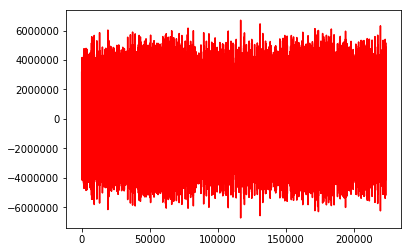

Cor 1: 5000


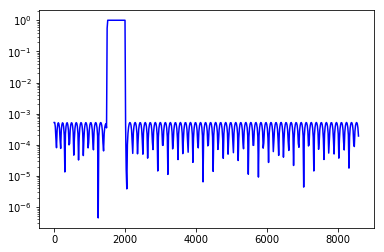

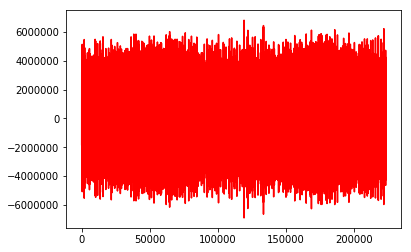

Cor 2: 5000


In [28]:
noise = np.array(scipy.io.wavfile.read('./data/iono-othr1.wav')[1], dtype=np.float)
noise = np.concatenate([noise, noise])
T = 13
fs = float(len(noise)) / T
NOISE_DB = 45 # dB
TX_DB = 18.5 # dB
# TX_DB = 25 # dB

ts = np.linspace(0, T, T*fs, endpoint=False)
chirp = scipy.signal.chirp(ts, f0=1500, t1=T, f1=2000, method='linear')
sig = np.power(10,
    TX_DB / 10)*(chirp.copy() / np.max(chirp)) + np.power(10, NOISE_DB / 10)*(noise / np.max(noise))

delayed = delay_sig(sig, 5000)
cor1 = xcorr(delayed,chirp)

plt.plot(fftshift(cor1), c='r')
plt.show()

print('Cor 1: ' + str(np.argmax(cor1)))

cfreq = (1500 + 2000) / 2
passw = (2000 - 1500) / 2
stop_l = cfreq - 1.05 * passw
stop_h = cfreq + 1.05 * passw

bpf = design_remez(5000, cfreq, passw, stop_l, stop_h, fs)
freq, response = scipy.signal.freqz(bpf)
plt.semilogy(0.5*fs*freq/np.pi, np.abs(response), 'b-')
plt.show()

filtd = scipy.signal.lfilter(bpf, [1], delayed)

bands = np.array([1.8e6, stop_l, cfreq - passw, cfreq + passw, stop_h, 20.2e6])
bpf = scipy.signal.remez(5000, bands, [0, 1, 0], fs=fs, type='bandpass')
filtd = scipy.signal.lfilter(bpf, [1], filtd)

cor2 = xcorr(filtd, chirp)
plt.plot(fftshift(cor2), c='r')
plt.show()

cfreq = (1500 + 2000) / 2
passw = (2000 - 1500) / 2
stop_l = cfreq - 1 * passw
stop_h = cfreq + 1 * passw

print('Cor 2: ' + str(np.argmax(cor2) - round((len(bpf) - 1) / 2)))

In [29]:
fs

17191.384615384617